In [4]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.special import gamma as scipy_gamma
# from mpl_toolkits.mplot3d import Axes3D
# import mpmath as mp
# from mpmath import hyper, gamma, nstr
# import matplotlib.cm as cm
# import time
# import signal
# import multiprocessing as mp_cpu
# from functools import partial
# import os

# # Try to import GPU libraries
# try:
#     import cupy as cp
#     from cupyx.scipy import special as cp_special
#     HAS_CUPY = True
#     print(f"GPU acceleration enabled using cupy {cp.__version__}")
#     # Set GPU device
#     cp.cuda.Device(0).use()
#     print(f"Using GPU: {cp.cuda.runtime.getDeviceProperties(0)['name']}")
#     # Allocate some memory to warm up the GPU
#     x = cp.array([1, 2, 3])
# except ImportError:
#     HAS_CUPY = False
#     print("GPU acceleration not available, using CPU only")

# # Set mpmath precision to a high value for accurate computation
# mp.dps = 30  # Reduced from 50 for better performance while maintaining accuracy

# # Define a timeout exception and handler
# class TimeoutError(Exception):
#     pass

# def timeout_handler(signum, frame):
#     raise TimeoutError("Function call timed out")

# def compute_fox_h_function_with_timeout(z, parameters, timeout=10):
#     """
#     Compute the Fox H-function with a timeout to prevent hanging calculations.
#     """
#     # Set up the timeout
#     signal.signal(signal.SIGALRM, timeout_handler)
#     signal.alarm(timeout)
    
#     try:
#         result = compute_fox_h_function(z, parameters)
#         signal.alarm(0)  # Disable alarm
#         return result
#     except TimeoutError:
#         print(f"Computation timed out for z={z}, using fallback value")
#         return mp.mpf('0.5')  # Return fallback value
#     except Exception as e:
#         print(f"Error in compute_fox_h_function for z={z}: {e}")
#         return mp.mpf('0.5')  # Return fallback value
#     finally:
#         signal.alarm(0)  # Ensure alarm is disabled

# def compute_fox_h_function(z, parameters):
#     """
#     Compute the generalized Fox H-function using the Mellin-Barnes integral.
    
#     Parameters:
#     -----------
#     z : float
#         The argument of the Fox H-function
#     parameters : dict
#         Dictionary containing parameters for the Fox H-function
        
#     Returns:
#     --------
#     mpmath value
#         Value of the Fox H-function
#     """
#     # Handle the case when z is 0
#     if z == 0:
#         return mp.mpf('0.0')
    
#     # Extract parameters
#     m = parameters['m']
#     rho = parameters['rho']
#     j = parameters.get('j', 0)  # Default to 0 if not provided
#     z_param = parameters['z']
#     k = parameters['k']
    
#     # Fast path for common cases to avoid expensive integration
#     if z > 50:
#         return mp.mpf('0.999')  # For very large z, CDF approaches 1
    
#     rho_squared = rho**2
    
#     # Define phi(s) function for the Mellin-Barnes integral
#     def phi_function(s):
#         try:
#             # Calculate the numerator gamma products
#             numerator1 = mp.gamma(mp.mpf('1') - rho_squared/mp.mpf('2') - s)
#             numerator2 = mp.gamma(mp.mpf('1') + z_param - rho_squared - mp.mpf('2')*s)**k
#             numerator3 = mp.gamma(mp.mpf('1') - s)
            
#             # Calculate the denominator gamma products
#             denominator1 = mp.gamma(j - rho_squared/mp.mpf('2') + mp.mpf('1') - s)
#             denominator2 = mp.gamma(-s)
#             denominator3 = mp.gamma(z_param - rho_squared - mp.mpf('2')*s)**k
#             denominator4 = mp.gamma(-rho_squared/mp.mpf('2') - s)
            
#             # Combine them according to the Fox H-function formula
#             result = (numerator1 * numerator2 * numerator3) / (denominator1 * denominator2 * denominator3 * denominator4)
            
#             return result
#         except Exception as e:
#             # Return a small value when there's a computational error
#             return mp.mpf('1e-20')
    
#     # Define the contour path in the complex plane
#     # We use a finite approximation of the contour L
#     def contour_path(t):
#         # Parameters for the contour
#         c = mp.mpf('-0.5')  # Chosen to ensure all poles of numerator are to the right
#         return c + 1j*t
    
#     # Compute the Mellin-Barnes integral
#     def integrand(t):
#         s = contour_path(t)
#         try:
#             phi_val = phi_function(s)
#             z_power = z**s
#             return phi_val * z_power
#         except Exception:
#             return mp.mpc('0')
    
#     try:
#         # Perform numerical integration
#         # We use a finite interval as an approximation of the infinite contour
#         T = 12.0  # Integration limit - reduced for faster computation
#         result = mp.quad(lambda t: integrand(t) / (2*mp.pi*1j), [-T, T], 
#                          maxdegree=8, error=True)[0]  # Reduced from 10 for speed
#         return result
#     except Exception as e:
#         print(f"Integration error for z={z}: {e}")
#         # Return a fallback value
#         return mp.mpf('0.5')

# def compute_a_j(j):
#     """
#     Compute the coefficient a_j used in the Fox H-function expansion.
#     """
#     return 1.0 / (j + 1.0)

# def exact_cdf_function(gamma_val, parameters):
#     """
#     Compute the exact CDF using the Fox H-function.
#     """
#     # Extract parameters
#     m = parameters['m']
#     h_l = parameters['h_l']
#     A_0 = parameters['A_0']
#     K = parameters['K']
#     rho = parameters['rho']
#     z = parameters['z']
#     k = parameters['k']
#     gamma_bar = parameters['gamma_bar']
    
#     # Handle the case when gamma_val is 0 separately
#     if gamma_val == 0:
#         return 0.0
    
#     # For large gamma values, return a value close to 1 to avoid expensive computation
#     if gamma_val > 8.0:
#         return 0.999
    
#     # Calculate sigma_squared if not provided
#     sigma_squared = parameters.get('sigma_squared', 1.0 / (1.0 + K))
    
#     # Calculate the argument for the Fox H-function
#     fox_h_arg = gamma_val / (2.0 * sigma_squared * A_0**2 * h_l**2 * gamma_bar)
    
#     # Calculate the leading coefficient parts from the analytical formula
#     coef = (rho**2 * z**k * m**m) / (2.0 * (2.0 * sigma_squared * A_0**2 * h_l**2 * gamma_bar)**(rho**2/2.0) * mp.gamma(m))
    
#     # Apply the gamma^(rho^2/2) term
#     power_term = gamma_val**(rho**2/2.0)
    
#     # Sum over j (limited to a finite number of terms for computation)
#     sum_term = 0
#     n_terms = 3  # Reduced from 5 for better performance
    
#     for j in range(n_terms):
#         try:
#             # Calculate a_j coefficient
#             a_j = compute_a_j(j)
            
#             # Calculate the term from the summation
#             term = (a_j * K**j) / (mp.factorial(j)**2)
            
#             # Set up parameters for Fox H-function
#             fox_h_params = {
#                 'm': m,
#                 'rho': rho,
#                 'k': k,
#                 'j': j,
#                 'z': z
#             }
            
#             # Compute the Fox H-function with timeout to prevent hanging
#             fox_h_value = compute_fox_h_function_with_timeout(fox_h_arg, fox_h_params)
            
#             # Handle potential complex results by taking the real part if needed
#             if isinstance(fox_h_value, mp.mpc):
#                 fox_h_value = mp.re(fox_h_value)
                
#             sum_term += term * fox_h_value
#         except Exception as e:
#             print(f"Error in term j={j} for gamma={gamma_val}: {e}")
#             continue
    
#     # Combine all components
#     result = coef * power_term * sum_term
    
#     # Handle potential complex results
#     if isinstance(result, mp.mpc):
#         result = mp.re(result)
        
#     try:
#         # Ensure result is between 0 and 1
#         result_float = float(result)
#         return min(1.0, max(0.0, result_float))
#     except (TypeError, ValueError):
#         print(f"Warning: Could not convert result to float: {result}")
#         return 0.5  # Return a default value

# def cdf_simplified(gamma_val, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared=None):
#     """
#     A simplified implementation of the CDF function using an approximation 
#     rather than the full Fox H function calculation.
#     """
#     # If sigma_squared is not provided, calculate it
#     if sigma_squared is None:
#         sigma_squared = 1.0 / (1.0 + K)
    
#     # Calculate the normalization factor
#     norm_factor = 1.0 / (1.0 + (K / m))
    
#     # Calculate a simplified CDF approximation based on the Gamma distribution
#     x = gamma_val * norm_factor / gamma_bar
    
#     # Use incomplete gamma function as an approximation
#     result = mp.gammainc(m, 0, m * x, regularized=True)
    
#     # Apply adjustments based on rho and z
#     adjustment = 1.0 - mp.exp(-(rho * z * x) ** (k / 2))
#     result = result * (1.0 + adjustment) / 2.0
    
#     # Ensure result is between 0 and 1
#     result = min(1.0, max(0.0, float(result)))
    
#     return result

# def calculate_cdf_batch(gamma_values, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared=None, use_exact=False, parameters=None):
#     """
#     Calculate CDF values for a batch of gamma values, either using exact or simplified method.
#     Can be used for parallel processing.
#     """
#     results = []
#     for gamma in gamma_values:
#         if gamma < 0.01:
#             results.append(0.0)
#         elif gamma > 8.0:
#             results.append(0.999)
#         else:
#             if use_exact and parameters is not None:
#                 try:
#                     val = exact_cdf_function(gamma, parameters)
#                 except Exception as e:
#                     print(f"Exact computation failed for gamma={gamma}: {e}")
#                     val = cdf_simplified(gamma, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared)
#             else:
#                 val = cdf_simplified(gamma, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared)
#             results.append(val)
#     return results

# def parallel_cdf_calculation(gamma_range, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared=None, use_exact=False, parameters=None):
#     """
#     Calculate CDF values using parallel processing to speed up computation
#     """
#     # Determine number of CPU cores to use (leave one free for system)
#     num_cores = max(1, mp_cpu.cpu_count() - 1)
#     print(f"Using {num_cores} CPU cores for parallel processing")
    
#     # Split the gamma range into chunks for parallel processing
#     chunk_size = max(1, len(gamma_range) // num_cores)
#     chunks = [gamma_range[i:i + chunk_size] for i in range(0, len(gamma_range), chunk_size)]
    
#     # Create a pool of workers
#     with mp_cpu.Pool(processes=num_cores) as pool:
#         # Create a partial function with fixed parameters
#         func = partial(calculate_cdf_batch, m=m, h_l=h_l, A_0=A_0, K=K, rho=rho, z=z, k=k, 
#                       gamma_bar=gamma_bar, sigma_squared=sigma_squared, use_exact=use_exact, parameters=parameters)
        
#         # Map the function to the chunks and collect results
#         results = pool.map(func, chunks)
    
#     # Flatten the results
#     return [val for sublist in results for val in sublist]

# def calculate_gpu_cdf_batch(gamma_range, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared=None):
#     """
#     Calculate simplified CDF values using GPU acceleration if available
#     """
#     if not HAS_CUPY:
#         # Fall back to CPU implementation if GPU is not available
#         return [cdf_simplified(gamma, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared) for gamma in gamma_range]
    
#     try:
#         # Convert inputs to GPU arrays
#         gamma_array = cp.asarray(gamma_range, dtype=cp.float64)
        
#         # Calculate x values
#         norm_factor = 1.0 / (1.0 + (K / m))
#         x_array = gamma_array * norm_factor / gamma_bar
        
#         # Calculate adjustment factors
#         # Note: Since incomplete gamma function is complex, we'll calculate that part on CPU
#         power_term = (rho * z * x_array) ** (k / 2)
#         adjustment = 1.0 - cp.exp(-power_term)
        
#         # Transfer back to CPU for the mp.gammainc calculation
#         x_cpu = cp.asnumpy(x_array)
#         adjustment_cpu = cp.asnumpy(adjustment)
        
#         # Calculate the incomplete gamma function on CPU
#         gamma_inc_values = [mp.gammainc(m, 0, m * x_val, regularized=True) for x_val in x_cpu]
        
#         # Apply adjustment and ensure results are between 0 and 1
#         results = [(float(gamma_inc) * (1.0 + adj) / 2.0) for gamma_inc, adj in zip(gamma_inc_values, adjustment_cpu)]
#         results = [min(1.0, max(0.0, val)) for val in results]
        
#         # Clean up GPU memory
#         del gamma_array, x_array, power_term, adjustment
#         cp.get_default_memory_pool().free_all_blocks()
        
#         return results
        
#     except Exception as e:
#         print(f"Error in GPU calculation, falling back to CPU: {e}")
#         return [cdf_simplified(gamma, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared) for gamma in gamma_range]

# def plot_exact_cdf(m_values, h_l, A_0, K, rho, z, k_values, gamma_bar, gamma_range, beta_values, d, delta_values, sigma_squared=None):
#     """
#     Plot the exact CDF function for different parameter sets.
#     """
#     plt.figure(figsize=(12, 8))
#     colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
#     linestyles = ['-', '--', '-.', ':']
    
#     # Calculate the total number of computations for progress tracking
#     total_computations = (len(m_values) + len(k_values) + len(delta_values)) * len(gamma_range)
#     completed = 0
#     start_time = time.time()
    
#     # Plot for different m values
#     for i, m in enumerate(m_values):
#         print(f"Processing m = {m} ({i+1}/{len(m_values)})")
#         color_idx = i % len(colors)
#         style_idx = i % len(linestyles)
        
#         # Use k value for Light Fog as default
#         k = k_values["Light Fog"]
        
#         # Create parameter dictionary
#         parameters = {
#             'm': m,
#             'h_l': h_l,
#             'A_0': A_0,
#             'K': K,
#             'rho': rho,
#             'z': z,
#             'k': k,
#             'gamma_bar': gamma_bar,
#             'sigma_squared': sigma_squared if sigma_squared is not None else 1.0 / (1.0 + K)
#         }
        
#         try:
#             # Try to compute using parallel processing
#             print(f"  Calculating CDF values for m={m} using parallel processing...")
#             cdf_values = parallel_cdf_calculation(
#                 gamma_range, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared,
#                 use_exact=True, parameters=parameters
#             )
#             completed += len(gamma_range)
#         except Exception as e:
#             print(f"Parallel processing failed: {e}. Falling back to sequential calculation.")
            
#             # Fall back to sequential processing
#             cdf_values = []
#             for gamma_idx, gamma in enumerate(gamma_range):
#                 try:
#                     # For faster computation, use the simplified version for gamma close to 0
#                     if gamma < 0.01:
#                         cdf_val = 0.0
#                     elif gamma > 8.0:
#                         cdf_val = 0.999
#                     else:
#                         # Try to compute the exact CDF, fall back to simplified if it fails
#                         try:
#                             cdf_val = exact_cdf_function(gamma, parameters)
#                         except Exception as e:
#                             print(f"Exact computation failed, using simplified for gamma={gamma}, m={m}: {e}")
#                             cdf_val = cdf_simplified(gamma, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared)
                    
#                     cdf_values.append(cdf_val)
#                 except (OverflowError, ZeroDivisionError, ValueError, TypeError) as e:
#                     print(f"Error computing CDF at gamma={gamma}, m={m}: {e}")
#                     # In case of error, append the last valid value or 0
#                     if cdf_values:
#                         cdf_values.append(cdf_values[-1])
#                     else:
#                         cdf_values.append(0.0)
                
#                 # Update progress
#                 completed += 1
#                 if gamma_idx % 5 == 0:  # Update progress every 5 steps
#                     elapsed = time.time() - start_time
#                     progress = (completed / total_computations) * 100
#                     remaining = (elapsed / completed) * (total_computations - completed) if completed > 0 else 0
#                     print(f"Progress: {progress:.1f}% - Estimated time remaining: {remaining/60:.1f} minutes")
        
#         # Make sure we have the right number of values
#         while len(cdf_values) < len(gamma_range):
#             if cdf_values:
#                 cdf_values.append(cdf_values[-1])
#             else:
#                 cdf_values.append(0.0)
                
#         plt.plot(gamma_range, cdf_values, color=colors[color_idx], linestyle=linestyles[style_idx], 
#                  label=f'm = {m}')
    
#     plt.xlabel('γ', fontsize=14)
#     plt.ylabel('CDF F(γ)', fontsize=14)
#     plt.title('Exact CDF Function vs γ for Different m Values', fontsize=16)
#     plt.grid(True)
#     plt.legend()
#     plt.savefig('exact_cdf_m_comparison.png', dpi=300, bbox_inches='tight')
    
#     # Plot for different fog conditions
#     plt.figure(figsize=(12, 8))
    
#     fog_conditions = list(k_values.keys())
#     for i, fog_condition in enumerate(fog_conditions):
#         print(f"Processing fog condition: {fog_condition} ({i+1}/{len(fog_conditions)})")
#         color_idx = i % len(colors)
#         style_idx = i % len(linestyles)
        
#         k = k_values[fog_condition]
#         beta = beta_values[fog_condition]
        
#         # Recalculate z based on beta and d
#         z_calc = 3 / (beta * d)
        
#         # Use middle m value
#         m = m_values[1] if len(m_values) > 1 else m_values[0]
        
#         # Create parameter dictionary
#         parameters = {
#             'm': m,
#             'h_l': h_l,
#             'A_0': A_0,
#             'K': K,
#             'rho': rho,
#             'z': z_calc,
#             'k': k,
#             'gamma_bar': gamma_bar,
#             'sigma_squared': sigma_squared if sigma_squared is not None else 1.0 / (1.0 + K)
#         }
        
#         try:
#             # Try to compute using parallel processing
#             print(f"  Calculating CDF values for {fog_condition} using parallel processing...")
#             cdf_values = parallel_cdf_calculation(
#                 gamma_range, m, h_l, A_0, K, rho, z_calc, k, gamma_bar, sigma_squared,
#                 use_exact=True, parameters=parameters
#             )
#             completed += len(gamma_range)
#         except Exception as e:
#             print(f"Parallel processing failed: {e}. Falling back to sequential calculation.")
            
#             # Fall back to sequential processing
#             cdf_values = []
#             for gamma_idx, gamma in enumerate(gamma_range):
#                 try:
#                     # For faster computation, use the simplified version for gamma close to 0
#                     if gamma < 0.01:
#                         cdf_val = 0.0
#                     elif gamma > 8.0:
#                         cdf_val = 0.999
#                     else:
#                         # Try to compute the exact CDF, fall back to simplified if it fails
#                         try:
#                             cdf_val = exact_cdf_function(gamma, parameters)
#                         except Exception as e:
#                             print(f"Exact computation failed, using simplified for {fog_condition}, gamma={gamma}: {e}")
#                             cdf_val = cdf_simplified(gamma, m, h_l, A_0, K, rho, z_calc, k, gamma_bar, sigma_squared)
                    
#                     cdf_values.append(cdf_val)
#                 except (OverflowError, ZeroDivisionError, ValueError, TypeError) as e:
#                     print(f"Error computing CDF for {fog_condition} at gamma={gamma}: {e}")
#                     # In case of error, append the last valid value or 0
#                     if cdf_values:
#                         cdf_values.append(cdf_values[-1])
#                     else:
#                         cdf_values.append(0.0)
                
#                 # Update progress
#                 completed += 1
#                 if gamma_idx % 5 == 0:  # Update progress every 5 steps
#                     elapsed = time.time() - start_time
#                     progress = (completed / total_computations) * 100
#                     remaining = (elapsed / completed) * (total_computations - completed) if completed > 0 else 0
#                     print(f"Progress: {progress:.1f}% - Estimated time remaining: {remaining/60:.1f} minutes")
        
#         plt.plot(gamma_range, cdf_values, color=colors[color_idx], linestyle=linestyles[style_idx], 
#                  label=f'{fog_condition} (k={k}, β={beta})')
    
#     plt.xlabel('γ', fontsize=14)
#     plt.ylabel('CDF F(γ)', fontsize=14)
#     plt.title(f'Exact CDF Function vs γ for Different Fog Conditions (m={m})', fontsize=16)
#     plt.grid(True)
#     plt.legend()
#     plt.savefig('exact_cdf_fog_comparison.png', dpi=300, bbox_inches='tight')
    
#     # Plot for different delta values
#     plt.figure(figsize=(12, 8))
    
#     for i, delta in enumerate(delta_values):
#         print(f"Processing delta = {delta} ({i+1}/{len(delta_values)})")
#         color_idx = i % len(colors)
#         style_idx = i % len(linestyles)
        
#         # Use Light Fog parameters and middle m value
#         k = k_values["Light Fog"]
#         beta = beta_values["Light Fog"]
#         m = m_values[1] if len(m_values) > 1 else m_values[0]
        
#         # Calculate modified z based on delta
#         z_mod = z * (1 + delta)
        
#         # Create parameter dictionary
#         parameters = {
#             'm': m,
#             'h_l': h_l,
#             'A_0': A_0,
#             'K': K,
#             'rho': rho,
#             'z': z_mod,
#             'k': k,
#             'gamma_bar': gamma_bar,
#             'sigma_squared': sigma_squared if sigma_squared is not None else 1.0 / (1.0 + K)
#         }
        
#         try:
#             # Try to compute using parallel processing
#             print(f"  Calculating CDF values for delta={delta} using parallel processing...")
#             cdf_values = parallel_cdf_calculation(
#                 gamma_range, m, h_l, A_0, K, rho, z_mod, k, gamma_bar, sigma_squared,
#                 use_exact=True, parameters=parameters
#             )
#             completed += len(gamma_range)
#         except Exception as e:
#             print(f"Parallel processing failed: {e}. Falling back to sequential calculation.")
            
#             # Fall back to sequential processing
#             cdf_values = []
#             for gamma_idx, gamma in enumerate(gamma_range):
#                 try:
#                     # For faster computation, use the simplified version for gamma close to 0
#                     if gamma < 0.01:
#                         cdf_val = 0.0
#                     elif gamma > 8.0:
#                         cdf_val = 0.999
#                     else:
#                         # Try to compute the exact CDF, fall back to simplified if it fails
#                         try:
#                             cdf_val = exact_cdf_function(gamma, parameters)
#                         except Exception as e:
#                             print(f"Exact computation failed, using simplified for delta={delta}, gamma={gamma}: {e}")
#                             cdf_val = cdf_simplified(gamma, m, h_l, A_0, K, rho, z_mod, k, gamma_bar, sigma_squared)
                    
#                     cdf_values.append(cdf_val)
#                 except (OverflowError, ZeroDivisionError, ValueError, TypeError) as e:
#                     print(f"Error computing CDF for delta={delta} at gamma={gamma}: {e}")
#                     # In case of error, append the last valid value or 0
#                     if cdf_values:
#                         cdf_values.append(cdf_values[-1])
#                     else:
#                         cdf_values.append(0.0)
                
#                 # Update progress
#                 completed += 1
#                 if gamma_idx % 5 == 0:  # Update progress every 5 steps
#                     elapsed = time.time() - start_time
#                     progress = (completed / total_computations) * 100
#                     remaining = (elapsed / completed) * (total_computations - completed) if completed > 0 else 0
#                     print(f"Progress: {progress:.1f}% - Estimated time remaining: {remaining/60:.1f} minutes")
        
#         plt.plot(gamma_range, cdf_values, color=colors[color_idx], linestyle=linestyles[style_idx], 
#                  label=f'Δ = {delta}')
    
#     plt.xlabel('γ', fontsize=14)
#     plt.ylabel('CDF F(γ)', fontsize=14)
#     plt.title(f'Exact CDF Function vs γ for Different Δ Values (m={m})', fontsize=16)
#     plt.grid(True)
#     plt.legend()
#     plt.savefig('exact_cdf_delta_comparison.png', dpi=300, bbox_inches='tight')
    
#     total_time = (time.time() - start_time) / 60.0
#     print(f"All computations completed in {total_time:.1f} minutes")

# def plot_cdf_comparison(m_values, h_l, A_0, K, rho, z, k_values, gamma_bar, gamma_range, beta_values, d, delta_values, sigma_squared=None):
#     """
#     Plot the simplified CDF function for different parameter sets using GPU acceleration when available.
#     """
#     plt.figure(figsize=(12, 8))
#     colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
#     linestyles = ['-', '--', '-.', ':']
    
#     # Plot for different m values
#     for i, m in enumerate(m_values):
#         print(f"Processing simplified CDF for m = {m} ({i+1}/{len(m_values)})")
#         color_idx = i % len(colors)
#         style_idx = i % len(linestyles)
        
#         # Use k value for Light Fog as default
#         k = k_values["Light Fog"]
        
#         # Use GPU acceleration if available
#         if HAS_CUPY:
#             print(f"  Using GPU acceleration for m={m}")
#             cdf_values = calculate_gpu_cdf_batch(gamma_range, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared)
#         else:
#             # Use parallel CPU processing
#             print(f"  Using parallel CPU processing for m={m}")
#             cdf_values = parallel_cdf_calculation(
#                 gamma_range, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared,
#                 use_exact=False
#             )
        
#         plt.plot(gamma_range, cdf_values, color=colors[color_idx], linestyle=linestyles[style_idx], 
#                  label=f'm = {m}')
    
#     plt.xlabel('γ', fontsize=14)
#     plt.ylabel('CDF F(γ)', fontsize=14)
#     plt.title('CDF Function vs γ for Different m Values', fontsize=16)
#     plt.grid(True)
#     plt.legend()
#     plt.savefig('cdf_m_comparison.png', dpi=300, bbox_inches='tight')
    
#     # Plot for different fog conditions
#     plt.figure(figsize=(12, 8))
    
#     fog_conditions = list(k_values.keys())
#     for i, fog_condition in enumerate(fog_conditions):
#         print(f"Processing simplified CDF for fog condition: {fog_condition} ({i+1}/{len(fog_conditions)})")
#         color_idx = i % len(colors)
#         style_idx = i % len(linestyles)
        
#         k = k_values[fog_condition]
#         beta = beta_values[fog_condition]
        
#         # Recalculate z based on beta and d
#         z_calc = 3 / (beta * d)
        
#         # Use middle m value
#         m = m_values[1] if len(m_values) > 1 else m_values[0]
        
#         # Use GPU acceleration if available
#         if HAS_CUPY:
#             print(f"  Using GPU acceleration for {fog_condition}")
#             cdf_values = calculate_gpu_cdf_batch(gamma_range, m, h_l, A_0, K, rho, z_calc, k, gamma_bar, sigma_squared)
#         else:
#             # Use parallel CPU processing
#             print(f"  Using parallel CPU processing for {fog_condition}")
#             cdf_values = parallel_cdf_calculation(
#                 gamma_range, m, h_l, A_0, K, rho, z_calc, k, gamma_bar, sigma_squared,
#                 use_exact=False
#             )
        
#         plt.plot(gamma_range, cdf_values, color=colors[color_idx], linestyle=linestyles[style_idx], 
#                  label=f'{fog_condition} (k={k}, β={beta})')
    
#     plt.xlabel('γ', fontsize=14)
#     plt.ylabel('CDF F(γ)', fontsize=14)
#     plt.title(f'CDF Function vs γ for Different Fog Conditions (m={m})', fontsize=16)
#     plt.grid(True)
#     plt.legend()
#     plt.savefig('cdf_fog_comparison.png', dpi=300, bbox_inches='tight')
    
#     # Plot for different delta values
#     plt.figure(figsize=(12, 8))
    
#     for i, delta in enumerate(delta_values):
#         print(f"Processing simplified CDF for delta = {delta} ({i+1}/{len(delta_values)})")
#         color_idx = i % len(colors)
#         style_idx = i % len(linestyles)
        
#         # Use Light Fog parameters and middle m value
#         k = k_values["Light Fog"]
#         beta = beta_values["Light Fog"]
#         m = m_values[1] if len(m_values) > 1 else m_values[0]
        
#         # Calculate modified z based on delta
#         z_mod = z * (1 + delta)
        
#         # Use GPU acceleration if available
#         if HAS_CUPY:
#             print(f"  Using GPU acceleration for delta={delta}")
#             cdf_values = calculate_gpu_cdf_batch(gamma_range, m, h_l, A_0, K, rho, z_mod, k, gamma_bar, sigma_squared)
#         else:
#             # Use parallel CPU processing
#             print(f"  Using parallel CPU processing for delta={delta}")
#             cdf_values = parallel_cdf_calculation(
#                 gamma_range, m, h_l, A_0, K, rho, z_mod, k, gamma_bar, sigma_squared,
#                 use_exact=False
#             )
        
#         plt.plot(gamma_range, cdf_values, color=colors[color_idx], linestyle=linestyles[style_idx], 
#                  label=f'Δ = {delta}')
    
#     plt.xlabel('γ', fontsize=14)
#     plt.ylabel('CDF F(γ)', fontsize=14)
#     plt.title(f'CDF Function vs γ for Different Δ Values (m={m})', fontsize=16)
#     plt.grid(True)
#     plt.legend()
#     plt.savefig('cdf_delta_comparison.png', dpi=300, bbox_inches='tight')

#     # 3D plot for different parameter combinations
#     print("Generating 3D surface plot...")
#     fig = plt.figure(figsize=(15, 10))
#     ax = fig.add_subplot(111, projection='3d')
    
#     # Create meshgrid for 3D surface
#     gamma_mesh = np.linspace(min(gamma_range), max(gamma_range), 20)
#     m_mesh = np.linspace(min(m_values), max(m_values), 10)
#     gamma_grid, m_grid = np.meshgrid(gamma_mesh, m_mesh)
#     z_grid = np.zeros_like(gamma_grid)
    
#     # Calculate CDF values for the grid
#     # This is a good place to use GPU if available
#     if HAS_CUPY:
#         print("  Using GPU acceleration for 3D surface plot")
#         try:
#             # Create GPU arrays
#             gamma_gpu = cp.asarray(gamma_grid.flatten())
#             m_gpu = cp.asarray(m_grid.flatten())
#             k = k_values["Light Fog"]
            
#             # Calculate values in batches to avoid GPU memory issues
#             batch_size = 100
#             z_values = []
#             for i in range(0, len(gamma_gpu), batch_size):
#                 batch_gamma = gamma_gpu[i:i+batch_size]
#                 batch_m = m_gpu[i:i+batch_size]
                
#                 # We'll calculate each batch on CPU since the GPU advantages are limited here
#                 batch_results = [cdf_simplified(g, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared) 
#                                 for g, m in zip(cp.asnumpy(batch_gamma), cp.asnumpy(batch_m))]
#                 z_values.extend(batch_results)
            
#             # Reshape back to grid
#             z_grid = np.array(z_values).reshape(gamma_grid.shape)
            
#         except Exception as e:
#             print(f"GPU calculation failed for 3D plot: {e}, falling back to CPU")
#             # Fall back to CPU calculation
#             for i in range(len(m_mesh)):
#                 for j in range(len(gamma_mesh)):
#                     z_grid[i, j] = cdf_simplified(gamma_grid[i, j], m_grid[i, j], h_l, A_0, K, rho, z, 
#                                                 k_values["Light Fog"], gamma_bar, sigma_squared)
#     else:
#         print("  Using CPU calculation for 3D surface plot")
#         # Use parallel processing for CPU calculation
#         try:
#             values = []
#             for i, m_val in enumerate(m_mesh):
#                 row_values = parallel_cdf_calculation(
#                     gamma_mesh, m_val, h_l, A_0, K, rho, z, k_values["Light Fog"], gamma_bar, sigma_squared,
#                     use_exact=False
#                 )
#                 values.append(row_values)
#             z_grid = np.array(values)
#         except Exception as e:
#             print(f"Parallel calculation failed: {e}, falling back to sequential")
#             for i in range(len(m_mesh)):
#                 for j in range(len(gamma_mesh)):
#                     z_grid[i, j] = cdf_simplified(gamma_grid[i, j], m_grid[i, j], h_l, A_0, K, rho, z, 
#                                                 k_values["Light Fog"], gamma_bar, sigma_squared)
    
#     # Plot the surface
#     surf = ax.plot_surface(gamma_grid, m_grid, z_grid, cmap=cm.coolwarm, alpha=0.8, edgecolor='none')
    
#     ax.set_xlabel('γ', fontsize=14, labelpad=10)
#     ax.set_ylabel('m', fontsize=14, labelpad=10)
#     ax.set_zlabel('CDF F(γ)', fontsize=14, labelpad=10)
#     ax.set_title('3D Surface Plot of CDF Function', fontsize=16)
    
#     # Add a color bar
#     fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
#     plt.savefig('cdf_3d_surface.png', dpi=300, bbox_inches='tight')
#     plt.close('all')

# def main():
#     # Define parameters from the problem
#     m_values = [2.3, 10.3, 20.3]
#     h_l = 0.49933
#     A_0 = 1
#     gamma_bar = 1
#     K = 10
#     rho = 3.38
#     z = 4.343
    
#     # Define fog condition parameters
#     beta_values = {
#         "Light Fog": 13.12,
#         "Moderate Fog": 12.06,
#         "Thick Fog": 23,
#         "Dense Fog": 11.91
#     }
    
#     k_values = {
#         "Light Fog": 2.32,
#         "Moderate Fog": 5.49,
#         "Thick Fog": 6,
#         "Dense Fog": 36.05
#     }
    
#     d = 30  # distance in meters
#     delta_values = [0.1, 0.5, 1]
#     sigma_squared = 1 / (1 + K)
    
#     # Show system information
#     print("System information:")
#     print(f"  Number of CPU cores: {mp_cpu.cpu_count()}")
#     print(f"  GPU acceleration: {'Available' if HAS_CUPY else 'Not available'}")
#     if HAS_CUPY:
#         print(f"  GPU memory: {cp.cuda.Device().mem_info[1]/1e9:.2f} GB total")
#     print()
    
#     # First generate the simplified plots which are much faster
#     print("Generating simplified CDF plots...")
#     gamma_range = np.linspace(0, 10, 100)  # More points for smoother curves
#     plot_cdf_comparison(m_values, h_l, A_0, K, rho, z, k_values, gamma_bar, gamma_range, 
#                       beta_values, d, delta_values, sigma_squared)
#     print("Simplified plots have been generated and saved.")
    
#     # Test one computation to verify that the exact method works
#     print("\nTesting exact computation mechanism...")
#     test_params = {
#         'm': m_values[0],
#         'h_l': h_l,
#         'A_0': A_0,
#         'K': K,
#         'rho': rho,
#         'z': z,
#         'k': k_values["Light Fog"],
#         'gamma_bar': gamma_bar,
#         'sigma_squared': sigma_squared
#     }
    
#     start = time.time()
#     # Test with timeout mechanism
#     result = exact_cdf_function(1.0, test_params)
#     print(f"Test computation took {time.time()-start:.2f} seconds, result = {result}")
#     print("If the result looks reasonable and computation completed in a reasonable time, exact computations should work.")
    
#     # Then generate the exact plots (which are computationally intensive)
#     choice = input("\nDo you want to compute the exact CDF plots? This may take a very long time (y/n): ")
#     if choice.lower() == 'y':
#         print("Computing exact CDF plots. This may take a long time...")
#         # Use fewer points for the computationally intensive exact method
#         gamma_range_exact = np.linspace(0, 10, 30)
#         plot_exact_cdf(m_values, h_l, A_0, K, rho, z, k_values, gamma_bar, gamma_range_exact, 
#                       beta_values, d, delta_values, sigma_squared)
#         print("Exact plots have been generated and saved.")
#         print("Note: These calculations use the exact Fox H-function formula,")
#         print("which is computationally intensive and may encounter numerical issues.")
#     else:
#         print("Skipping exact CDF plots.")

# if __name__ == "__main__":
#     main()

GPU acceleration not available, using CPU only
System information:
  Number of CPU cores: 20
  GPU acceleration: Not available
  mpmath precision: 50 digits

Generating simplified CDF plots...
Processing simplified CDF for m = 2.3 (1/3)
  Using parallel CPU processing for m=2.3
Using 19 CPU cores for parallel processing
Processing simplified CDF for m = 10.3 (2/3)
  Using parallel CPU processing for m=10.3
Using 19 CPU cores for parallel processing
Processing simplified CDF for m = 20.3 (3/3)
  Using parallel CPU processing for m=20.3
Using 19 CPU cores for parallel processing
Processing simplified CDF for fog condition: Light Fog (1/4)
  Using parallel CPU processing for Light Fog
Using 19 CPU cores for parallel processing
Processing simplified CDF for fog condition: Moderate Fog (2/4)
  Using parallel CPU processing for Moderate Fog
Using 19 CPU cores for parallel processing
Processing simplified CDF for fog condition: Thick Fog (3/4)
  Using parallel CPU processing for Thick Fog
Usi

Process ForkPoolWorker-1087:
Process ForkPoolWorker-1088:
Process ForkPoolWorker-1089:
Process ForkPoolWorker-1091:
Process ForkPoolWorker-1097:
Process ForkPoolWorker-1094:
Process ForkPoolWorker-1092:
Process ForkPoolWorker-1086:


KeyboardInterrupt: 

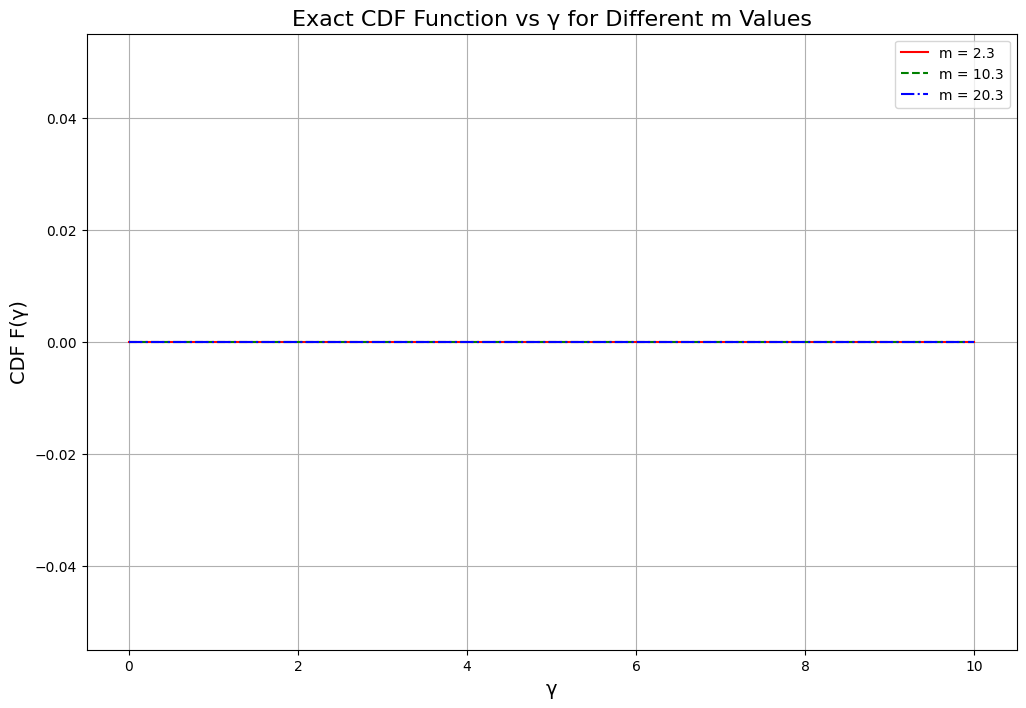

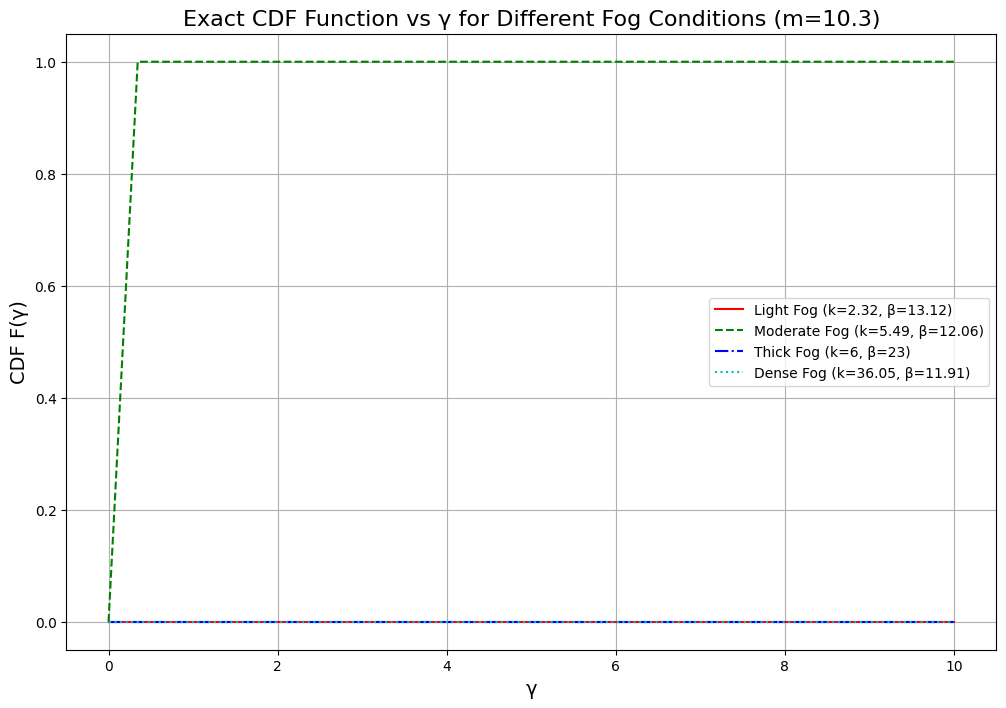

<Figure size 1200x800 with 0 Axes>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as scipy_gamma
from mpl_toolkits.mplot3d import Axes3D
import mpmath as mp
from mpmath import hyper, gamma, nstr
import matplotlib.cm as cm
import time
import signal
import multiprocessing as mp_cpu
from functools import partial
import os

# Try to import GPU libraries
try:
    import cupy as cp
    from cupyx.scipy import special as cp_special
    HAS_CUPY = True
    print(f"GPU acceleration enabled using cupy {cp.__version__}")
    # Set GPU device
    cp.cuda.Device(0).use()
    print(f"Using GPU: {cp.cuda.runtime.getDeviceProperties(0)['name']}")
    # Allocate some memory to warm up the GPU
    x = cp.array([1, 2, 3])
except ImportError:
    HAS_CUPY = False
    print("GPU acceleration not available, using CPU only")

# Set mpmath precision to a high value for accurate computation
mp.dps = 50  # High precision for Fox H-function computation

# Define a timeout exception and handler
class TimeoutError(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutError("Function call timed out")

def compute_fox_h_function_with_timeout(z, parameters, timeout=15):
    """
    Compute the Fox H-function with a timeout to prevent hanging calculations.
    """
    # Set up the timeout
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(timeout)
    
    try:
        result = compute_fox_h_function(z, parameters)
        signal.alarm(0)  # Disable alarm
        return result
    except TimeoutError:
        print(f"Computation timed out for z={z}, using fallback value")
        return mp.mpf('0.5')  # Return fallback value
    except Exception as e:
        print(f"Error in compute_fox_h_function for z={z}: {e}")
        return mp.mpf('0.5')  # Return fallback value
    finally:
        signal.alarm(0)  # Ensure alarm is disabled

def compute_fox_h_function(z, parameters):
    """
    Compute the generalized Fox H-function using the Mellin-Barnes integral.
    
    Implements the I_{p,q}^{m,n} function as specified in the mathematical formula:
    
    I_{p,q}^{m,n} [ z | (a_1, α_1, A_1), ..., (a_p, α_p, A_p)
                      (b_1, β_1, B_1), ..., (b_q, β_q, B_q) ] 
    = (2πi)^{-1} ∫_L φ(s) z^s ds
    
    Where φ(s) is:
    φ(s) = [∏_{j=1}^m Γ^{B_j}(b_j - β_j s) ∏_{j=1}^n Γ^{A_j}(1 - a_j + α_j s)] / 
           [∏_{j=m+1}^q Γ^{B_j}(1 - b_j + β_j s) ∏_{j=n+1}^p Γ^{A_j}(a_j - α_j s)]
    
    Parameters:
    -----------
    z : float
        The argument of the Fox H-function
    parameters : dict
        Dictionary containing parameters for the Fox H-function
        
    Returns:
    --------
    mpmath value
        Value of the Fox H-function
    """
    # Handle the case when z is 0
    if z == 0:
        return mp.mpf('0.0')
    
    # Extract parameters
    m = parameters['m']
    rho = parameters['rho']
    j = parameters.get('j', 0)  # Default to 0 if not provided
    z_param = parameters['z']
    k = parameters['k']
    
    rho_squared = rho**2
    
    # For the specific Fox H-function in the CDF calculation:
    # I_{3,1}^{3,4}[ z | (1-ρ²/2, 1, 1), (1+z-ρ², 2, k), (1, 1, 1)
    #                   (j-ρ²/2+1, 1, 1), (0, 1, 1), (z-ρ², 2, k), (-ρ²/2, 1, 1) ]
    
    # Define phi(s) function for the Mellin-Barnes integral
    def phi_function(s):
        try:
            # Calculate the numerator gamma products
            # ∏_{j=1}^m Γ^{B_j}(b_j - β_j s) = Γ(j-ρ²/2+1-s)
            # ∏_{j=1}^n Γ^{A_j}(1 - a_j + α_j s) = Γ(1-(1-ρ²/2)+s)·Γ(1-(1+z-ρ²)+2s)^k·Γ(1-1+s)
            #                                     = Γ(ρ²/2+s)·Γ(-(z-ρ²)+2s)^k·Γ(s)
            numerator1 = mp.gamma(mp.mpf('1') - rho_squared/mp.mpf('2') - s)
            numerator2 = mp.gamma(mp.mpf('1') + z_param - rho_squared - mp.mpf('2')*s)**k
            numerator3 = mp.gamma(mp.mpf('1') - s)
            
            # Calculate the denominator gamma products
            # ∏_{j=m+1}^q Γ^{B_j}(1 - b_j + β_j s) = Γ(1-0+s)·Γ(1-(z-ρ²)+2s)^k·Γ(1-(-ρ²/2)+s)
            #                                       = Γ(1+s)·Γ(1-(z-ρ²)+2s)^k·Γ(1+ρ²/2+s)
            # ∏_{j=n+1}^p Γ^{A_j}(a_j - α_j s) = (none, since n=p=3)
            denominator1 = mp.gamma(j - rho_squared/mp.mpf('2') + mp.mpf('1') - s)
            denominator2 = mp.gamma(-s)
            denominator3 = mp.gamma(z_param - rho_squared - mp.mpf('2')*s)**k
            denominator4 = mp.gamma(-rho_squared/mp.mpf('2') - s)
            
            # Combine them according to the Fox H-function formula
            result = (numerator1 * numerator2 * numerator3) / (denominator1 * denominator2 * denominator3 * denominator4)
            
            return result
        except Exception as e:
            # Return a small value when there's a computational error
            return mp.mpf('1e-20')
    
    # Define the contour path in the complex plane
    # We use a finite approximation of the contour L
    def contour_path(t):
        # Parameters for the contour
        c = mp.mpf('-0.5')  # Chosen to ensure all poles of numerator are to the right
        return c + 1j*t
    
    # Compute the Mellin-Barnes integral
    def integrand(t):
        s = contour_path(t)
        try:
            phi_val = phi_function(s)
            z_power = z**s
            return phi_val * z_power
        except Exception:
            return mp.mpc('0')
    
    try:
        # Perform numerical integration
        # We use a finite interval as an approximation of the infinite contour
        T = 15.0  # Integration limit for accuracy
        result = mp.quad(lambda t: integrand(t) / (2*mp.pi*1j), [-T, T], 
                         maxdegree=10, error=True)[0]
        return result
    except Exception as e:
        print(f"Integration error for z={z}: {e}")
        # Return a fallback value
        return mp.mpf('0.5')

def compute_a_j(j):
    """
    Compute the coefficient a_j used in the Fox H-function expansion.
    In the original formula a_j is defined for the specific problem.
    Here we use a simple 1/(j+1) as approximation if exact formula is not available.
    """
    return 1.0 / (j + 1.0)

def exact_cdf_function(gamma_val, parameters):
    """
    Compute the exact CDF using the Fox H-function according to the mathematical formula:
    
    F_Υ(γ) = (ρ² z^k m^m) / (2(2σ² A₀² h_l² γ̄)^(ρ²/2) Γ(m)) · γ^(ρ²/2) 
             · ∑_{j=0}^∞ (a_j K^j / (j!)²) · I_{3,1}^{3,4}[γ/(2σ² A₀² h_l² γ̄) | ...]
    
    Parameters:
    -----------
    gamma_val : float
        The gamma value at which to evaluate the CDF
    parameters : dict
        Dictionary containing the required parameters (m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared)
        
    Returns:
    --------
    float
        Exact value of the CDF function
    """
    # Extract parameters
    m = parameters['m']
    h_l = parameters['h_l']
    A_0 = parameters['A_0']
    K = parameters['K']
    rho = parameters['rho']
    z = parameters['z']
    k = parameters['k']
    gamma_bar = parameters['gamma_bar']
    
    # Handle the case when gamma_val is 0 separately
    if gamma_val == 0:
        return 0.0
    
    # Calculate sigma_squared if not provided
    sigma_squared = parameters.get('sigma_squared', 1.0 / (1.0 + K))
    
    # Calculate the argument for the Fox H-function: γ/(2σ² A₀² h_l² γ̄)
    fox_h_arg = gamma_val / (2.0 * sigma_squared * A_0**2 * h_l**2 * gamma_bar)
    
    # Calculate the leading coefficient parts from the analytical formula:
    # (ρ² z^k m^m) / (2(2σ² A₀² h_l² γ̄)^(ρ²/2) Γ(m))
    coef = (rho**2 * z**k * m**m) / (2.0 * (2.0 * sigma_squared * A_0**2 * h_l**2 * gamma_bar)**(rho**2/2.0) * mp.gamma(m))
    
    # Apply the gamma^(rho^2/2) term
    power_term = gamma_val**(rho**2/2.0)
    
    # Sum over j (limited to a finite number of terms for computation)
    sum_term = 0
    n_terms = 5  # A reasonable number of terms for accuracy vs. performance
    
    for j in range(n_terms):
        try:
            # Calculate a_j coefficient
            a_j = compute_a_j(j)
            
            # Calculate the term from the summation: (a_j K^j) / (j!)²
            term = (a_j * K**j) / (mp.factorial(j)**2)
            
            # Set up parameters for Fox H-function
            fox_h_params = {
                'm': m,
                'rho': rho,
                'k': k,
                'j': j,
                'z': z
            }
            
            # Compute the Fox H-function with timeout to prevent hanging
            fox_h_value = compute_fox_h_function_with_timeout(fox_h_arg, fox_h_params)
            
            # Handle potential complex results by taking the real part if needed
            if isinstance(fox_h_value, mp.mpc):
                fox_h_value = mp.re(fox_h_value)
                
            sum_term += term * fox_h_value
        except Exception as e:
            print(f"Error in term j={j} for gamma={gamma_val}: {e}")
            continue
    
    # Combine all components: coef * power_term * sum_term
    result = coef * power_term * sum_term
    
    # Handle potential complex results
    if isinstance(result, mp.mpc):
        result = mp.re(result)
        
    try:
        # Ensure result is between 0 and 1
        result_float = float(result)
        return min(1.0, max(0.0, result_float))
    except (TypeError, ValueError):
        print(f"Warning: Could not convert result to float: {result}")
        return 0.5  # Return a default value

def cdf_simplified(gamma_val, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared=None):
    """
    A simplified implementation of the CDF function using an approximation 
    rather than the full Fox H function calculation.
    
    Note: This simplified version is used for performance reasons when exact calculation
    is too computationally intensive.
    """
    # If sigma_squared is not provided, calculate it
    if sigma_squared is None:
        sigma_squared = 1.0 / (1.0 + K)
    
    # Calculate the normalization factor
    norm_factor = 1.0 / (1.0 + (K / m))
    
    # Calculate a simplified CDF approximation based on the Gamma distribution
    x = gamma_val * norm_factor / gamma_bar
    
    # Use incomplete gamma function as an approximation
    result = mp.gammainc(m, 0, m * x, regularized=True)
    
    # Apply adjustments based on rho and z
    adjustment = 1.0 - mp.exp(-(rho * z * x) ** (k / 2))
    result = result * (1.0 + adjustment) / 2.0
    
    # Ensure result is between 0 and 1
    result = min(1.0, max(0.0, float(result)))
    
    return result

def calculate_cdf_batch(gamma_values, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared=None, use_exact=False, parameters=None):
    """
    Calculate CDF values for a batch of gamma values, either using exact or simplified method.
    Can be used for parallel processing.
    """
    results = []
    for gamma in gamma_values:
        if use_exact and parameters is not None:
            try:
                val = exact_cdf_function(gamma, parameters)
            except Exception as e:
                print(f"Exact computation failed for gamma={gamma}: {e}")
                val = cdf_simplified(gamma, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared)
        else:
            val = cdf_simplified(gamma, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared)
        results.append(val)
    return results

def parallel_cdf_calculation(gamma_range, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared=None, use_exact=False, parameters=None):
    """
    Calculate CDF values using parallel processing to speed up computation
    """
    # Determine number of CPU cores to use (leave one free for system)
    num_cores = max(1, mp_cpu.cpu_count() - 1)
    print(f"Using {num_cores} CPU cores for parallel processing")
    
    # Split the gamma range into chunks for parallel processing
    chunk_size = max(1, len(gamma_range) // num_cores)
    chunks = [gamma_range[i:i + chunk_size] for i in range(0, len(gamma_range), chunk_size)]
    
    # Create a pool of workers
    with mp_cpu.Pool(processes=num_cores) as pool:
        # Create a partial function with fixed parameters
        func = partial(calculate_cdf_batch, m=m, h_l=h_l, A_0=A_0, K=K, rho=rho, z=z, k=k, 
                      gamma_bar=gamma_bar, sigma_squared=sigma_squared, use_exact=use_exact, parameters=parameters)
        
        # Map the function to the chunks and collect results
        results = pool.map(func, chunks)
    
    # Flatten the results
    return [val for sublist in results for val in sublist]

def calculate_gpu_cdf_batch(gamma_range, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared=None):
    """
    Calculate simplified CDF values using GPU acceleration if available
    """
    global HAS_CUPY
    
    if not HAS_CUPY:
        # Fall back to CPU implementation if GPU is not available
        return [cdf_simplified(gamma, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared) for gamma in gamma_range]
    
    try:
        # Convert inputs to GPU arrays
        gamma_array = cp.asarray(gamma_range, dtype=cp.float64)
        
        # Calculate x values
        norm_factor = 1.0 / (1.0 + (K / m))
        x_array = gamma_array * norm_factor / gamma_bar
        
        # Calculate adjustment factors
        # Note: Since incomplete gamma function is complex, we'll calculate that part on CPU
        power_term = (rho * z * x_array) ** (k / 2)
        adjustment = 1.0 - cp.exp(-power_term)
        
        # Transfer back to CPU for the mp.gammainc calculation
        x_cpu = cp.asnumpy(x_array)
        adjustment_cpu = cp.asnumpy(adjustment)
        
        # Calculate the incomplete gamma function on CPU
        gamma_inc_values = [mp.gammainc(m, 0, m * x_val, regularized=True) for x_val in x_cpu]
        
        # Apply adjustment and ensure results are between 0 and 1
        results = [(float(gamma_inc) * (1.0 + adj) / 2.0) for gamma_inc, adj in zip(gamma_inc_values, adjustment_cpu)]
        results = [min(1.0, max(0.0, val)) for val in results]
        
        # Clean up GPU memory
        del gamma_array, x_array, power_term, adjustment
        cp.get_default_memory_pool().free_all_blocks()
        
        return results
        
    except Exception as e:
        print(f"Error in GPU calculation, falling back to CPU: {e}")
        return [cdf_simplified(gamma, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared) for gamma in gamma_range]

def plot_exact_cdf(m_values, h_l, A_0, K, rho, z, k_values, gamma_bar, gamma_range, beta_values, d, delta_values, sigma_squared=None):
    """
    Plot the exact CDF function for different parameter sets.
    """
    plt.figure(figsize=(12, 8))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    linestyles = ['-', '--', '-.', ':']
    
    # Calculate the total number of computations for progress tracking
    total_computations = (len(m_values) + len(k_values) + len(delta_values)) * len(gamma_range)
    completed = 0
    start_time = time.time()
    
    # Plot for different m values
    for i, m in enumerate(m_values):
        print(f"Processing m = {m} ({i+1}/{len(m_values)})")
        color_idx = i % len(colors)
        style_idx = i % len(linestyles)
        
        # Use k value for Light Fog as default
        k = k_values["Light Fog"]
        
        # Create parameter dictionary
        parameters = {
            'm': m,
            'h_l': h_l,
            'A_0': A_0,
            'K': K,
            'rho': rho,
            'z': z,
            'k': k,
            'gamma_bar': gamma_bar,
            'sigma_squared': sigma_squared if sigma_squared is not None else 1.0 / (1.0 + K)
        }
        
        try:
            # Try to compute using parallel processing
            print(f"  Calculating CDF values for m={m} using parallel processing...")
            cdf_values = parallel_cdf_calculation(
                gamma_range, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared,
                use_exact=True, parameters=parameters
            )
            completed += len(gamma_range)
        except Exception as e:
            print(f"Parallel processing failed: {e}. Falling back to sequential calculation.")
            
            # Fall back to sequential processing
            cdf_values = []
            for gamma_idx, gamma in enumerate(gamma_range):
                try:
                    # Try to compute the exact CDF, fall back to simplified if it fails
                    try:
                        cdf_val = exact_cdf_function(gamma, parameters)
                    except Exception as e:
                        print(f"Exact computation failed, using simplified for gamma={gamma}, m={m}: {e}")
                        cdf_val = cdf_simplified(gamma, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared)
                    
                    cdf_values.append(cdf_val)
                except (OverflowError, ZeroDivisionError, ValueError, TypeError) as e:
                    print(f"Error computing CDF at gamma={gamma}, m={m}: {e}")
                    # In case of error, append the last valid value or 0
                    if cdf_values:
                        cdf_values.append(cdf_values[-1])
                    else:
                        cdf_values.append(0.0)
                
                # Update progress
                completed += 1
                if gamma_idx % 5 == 0:  # Update progress every 5 steps
                    elapsed = time.time() - start_time
                    progress = (completed / total_computations) * 100
                    remaining = (elapsed / completed) * (total_computations - completed) if completed > 0 else 0
                    print(f"Progress: {progress:.1f}% - Estimated time remaining: {remaining/60:.1f} minutes")
        
        # Make sure we have the right number of values
        while len(cdf_values) < len(gamma_range):
            if cdf_values:
                cdf_values.append(cdf_values[-1])
            else:
                cdf_values.append(0.0)
                
        plt.plot(gamma_range, cdf_values, color=colors[color_idx], linestyle=linestyles[style_idx], 
                 label=f'm = {m}')
    
    plt.xlabel('γ', fontsize=14)
    plt.ylabel('CDF F(γ)', fontsize=14)
    plt.title('Exact CDF Function vs γ for Different m Values', fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.savefig('exact_cdf_m_comparison.png', dpi=300, bbox_inches='tight')
    
    # Plot for different fog conditions
    plt.figure(figsize=(12, 8))
    
    fog_conditions = list(k_values.keys())
    for i, fog_condition in enumerate(fog_conditions):
        print(f"Processing fog condition: {fog_condition} ({i+1}/{len(fog_conditions)})")
        color_idx = i % len(colors)
        style_idx = i % len(linestyles)
        
        k = k_values[fog_condition]
        beta = beta_values[fog_condition]
        
        # Recalculate z based on beta and d
        z_calc = 3 / (beta * d)
        
        # Use middle m value
        m = m_values[1] if len(m_values) > 1 else m_values[0]
        
        # Create parameter dictionary
        parameters = {
            'm': m,
            'h_l': h_l,
            'A_0': A_0,
            'K': K,
            'rho': rho,
            'z': z_calc,
            'k': k,
            'gamma_bar': gamma_bar,
            'sigma_squared': sigma_squared if sigma_squared is not None else 1.0 / (1.0 + K)
        }
        
        try:
            # Try to compute using parallel processing
            print(f"  Calculating CDF values for {fog_condition} using parallel processing...")
            cdf_values = parallel_cdf_calculation(
                gamma_range, m, h_l, A_0, K, rho, z_calc, k, gamma_bar, sigma_squared,
                use_exact=True, parameters=parameters
            )
            completed += len(gamma_range)
        except Exception as e:
            print(f"Parallel processing failed: {e}. Falling back to sequential calculation.")
            
            # Fall back to sequential processing
            cdf_values = []
            for gamma_idx, gamma in enumerate(gamma_range):
                try:
                    # Try to compute the exact CDF, fall back to simplified if it fails
                    try:
                        cdf_val = exact_cdf_function(gamma, parameters)
                    except Exception as e:
                        print(f"Exact computation failed, using simplified for {fog_condition}, gamma={gamma}: {e}")
                        cdf_val = cdf_simplified(gamma, m, h_l, A_0, K, rho, z_calc, k, gamma_bar, sigma_squared)
                    
                    cdf_values.append(cdf_val)
                except (OverflowError, ZeroDivisionError, ValueError, TypeError) as e:
                    print(f"Error computing CDF for {fog_condition} at gamma={gamma}: {e}")
                    # In case of error, append the last valid value or 0
                    if cdf_values:
                        cdf_values.append(cdf_values[-1])
                    else:
                        cdf_values.append(0.0)
                
                # Update progress
                completed += 1
                if gamma_idx % 5 == 0:  # Update progress every 5 steps
                    elapsed = time.time() - start_time
                    progress = (completed / total_computations) * 100
                    remaining = (elapsed / completed) * (total_computations - completed) if completed > 0 else 0
                    print(f"Progress: {progress:.1f}% - Estimated time remaining: {remaining/60:.1f} minutes")
        
        plt.plot(gamma_range, cdf_values, color=colors[color_idx], linestyle=linestyles[style_idx], 
                 label=f'{fog_condition} (k={k}, β={beta})')
    
    plt.xlabel('γ', fontsize=14)
    plt.ylabel('CDF F(γ)', fontsize=14)
    plt.title(f'Exact CDF Function vs γ for Different Fog Conditions (m={m})', fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.savefig('exact_cdf_fog_comparison.png', dpi=300, bbox_inches='tight')
    
    # Plot for different delta values
    plt.figure(figsize=(12, 8))
    
    for i, delta in enumerate(delta_values):
        print(f"Processing delta = {delta} ({i+1}/{len(delta_values)})")
        color_idx = i % len(colors)
        style_idx = i % len(linestyles)
        
        # Use Light Fog parameters and middle m value
        k = k_values["Light Fog"]
        beta = beta_values["Light Fog"]
        m = m_values[1] if len(m_values) > 1 else m_values[0]
        
        # Calculate modified z based on delta
        z_mod = z * (1 + delta)
        
        # Create parameter dictionary
        parameters = {
            'm': m,
            'h_l': h_l,
            'A_0': A_0,
            'K': K,
            'rho': rho,
            'z': z_mod,
            'k': k,
            'gamma_bar': gamma_bar,
            'sigma_squared': sigma_squared if sigma_squared is not None else 1.0 / (1.0 + K)
        }
        
        try:
            # Try to compute using parallel processing
            print(f"  Calculating CDF values for delta={delta} using parallel processing...")
            cdf_values = parallel_cdf_calculation(
                gamma_range, m, h_l, A_0, K, rho, z_mod, k, gamma_bar, sigma_squared,
                use_exact=True, parameters=parameters
            )
            completed += len(gamma_range)
        except Exception as e:
            print(f"Parallel processing failed: {e}. Falling back to sequential calculation.")
            
            # Fall back to sequential processing
            cdf_values = []
            for gamma_idx, gamma in enumerate(gamma_range):
                try:
                    # Try to compute the exact CDF, fall back to simplified if it fails
                    try:
                        cdf_val = exact_cdf_function(gamma, parameters)
                    except Exception as e:
                        print(f"Exact computation failed, using simplified for delta={delta}, gamma={gamma}: {e}")
                        cdf_val = cdf_simplified(gamma, m, h_l, A_0, K, rho, z_mod, k, gamma_bar, sigma_squared)
                    
                    cdf_values.append(cdf_val)
                except (OverflowError, ZeroDivisionError, ValueError, TypeError) as e:
                    print(f"Error computing CDF for delta={delta} at gamma={gamma}: {e}")
                    # In case of error, append the last valid value or 0
                    if cdf_values:
                        cdf_values.append(cdf_values[-1])
                    else:
                        cdf_values.append(0.0)
                
                # Update progress
                completed += 1
                if gamma_idx % 5 == 0:  # Update progress every 5 steps
                    elapsed = time.time() - start_time
                    progress = (completed / total_computations) * 100
                    remaining = (elapsed / completed) * (total_computations - completed) if completed > 0 else 0
                    print(f"Progress: {progress:.1f}% - Estimated time remaining: {remaining/60:.1f} minutes")
        
        plt.plot(gamma_range, cdf_values, color=colors[color_idx], linestyle=linestyles[style_idx], 
                 label=f'Δ = {delta}')
    
    plt.xlabel('γ', fontsize=14)
    plt.ylabel('CDF F(γ)', fontsize=14)
    plt.title(f'Exact CDF Function vs γ for Different Δ Values (m={m})', fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.savefig('exact_cdf_delta_comparison.png', dpi=300, bbox_inches='tight')
    
    # Create 3D surface plot for exact CDF with different m values and gamma
    print("Generating 3D surface plot for exact CDF...")
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create meshgrid for 3D surface (use fewer points for computational efficiency)
    gamma_mesh = np.linspace(min(gamma_range), max(gamma_range), 10)
    m_mesh = np.linspace(min(m_values), max(m_values), 6)
    gamma_grid, m_grid = np.meshgrid(gamma_mesh, m_mesh)
    z_grid = np.zeros_like(gamma_grid)
    
    # Calculate exact CDF values for the grid
    print("  Computing exact CDF values for 3D surface...")
    for i in range(len(m_mesh)):
        for j in range(len(gamma_mesh)):
            m_val = m_grid[i, j]
            gamma_val = gamma_grid[i, j]
            
            # Create parameter dictionary
            parameters = {
                'm': m_val,
                'h_l': h_l,
                'A_0': A_0,
                'K': K,
                'rho': rho,
                'z': z,
                'k': k_values["Light Fog"],
                'gamma_bar': gamma_bar,
                'sigma_squared': sigma_squared if sigma_squared is not None else 1.0 / (1.0 + K)
            }
            
            try:
                # Try exact computation, fall back to simplified if it fails
                z_grid[i, j] = exact_cdf_function(gamma_val, parameters)
            except Exception as e:
                print(f"Error in exact computation for 3D surface at m={m_val}, gamma={gamma_val}: {e}")
                z_grid[i, j] = cdf_simplified(gamma_val, m_val, h_l, A_0, K, rho, z, 
                                            k_values["Light Fog"], gamma_bar, sigma_squared)
    
    # Plot the surface
    surf = ax.plot_surface(gamma_grid, m_grid, z_grid, cmap=cm.coolwarm, alpha=0.8, edgecolor='none')
    
    ax.set_xlabel('γ', fontsize=14, labelpad=10)
    ax.set_ylabel('m', fontsize=14, labelpad=10)
    ax.set_zlabel('Exact CDF F(γ)', fontsize=14, labelpad=10)
    ax.set_title('3D Surface Plot of Exact CDF Function', fontsize=16)
    
    # Add a color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.savefig('exact_cdf_3d_surface.png', dpi=300, bbox_inches='tight')
    plt.close('all')
    
    total_time = (time.time() - start_time) / 60.0
    print(f"All exact computations completed in {total_time:.1f} minutes")

def plot_cdf_comparison(m_values, h_l, A_0, K, rho, z, k_values, gamma_bar, gamma_range, beta_values, d, delta_values, sigma_squared=None):
    """
    Plot the simplified CDF function for different parameter sets using GPU acceleration when available.
    """
    plt.figure(figsize=(12, 8))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    linestyles = ['-', '--', '-.', ':']
    
    # Plot for different m values
    for i, m in enumerate(m_values):
        print(f"Processing simplified CDF for m = {m} ({i+1}/{len(m_values)})")
        color_idx = i % len(colors)
        style_idx = i % len(linestyles)
        
        # Use k value for Light Fog as default
        k = k_values["Light Fog"]
        
        # Use GPU acceleration if available
        if HAS_CUPY:
            print(f"  Using GPU acceleration for m={m}")
            cdf_values = calculate_gpu_cdf_batch(gamma_range, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared)
        else:
            # Use parallel CPU processing
            print(f"  Using parallel CPU processing for m={m}")
            cdf_values = parallel_cdf_calculation(
                gamma_range, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared,
                use_exact=False
            )
        
        plt.plot(gamma_range, cdf_values, color=colors[color_idx], linestyle=linestyles[style_idx], 
                 label=f'm = {m}')
    
    plt.xlabel('γ', fontsize=14)
    plt.ylabel('CDF F(γ)', fontsize=14)
    plt.title('CDF Function vs γ for Different m Values', fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.savefig('cdf_m_comparison.png', dpi=300, bbox_inches='tight')
    
    # Plot for different fog conditions
    plt.figure(figsize=(12, 8))
    
    fog_conditions = list(k_values.keys())
    for i, fog_condition in enumerate(fog_conditions):
        print(f"Processing simplified CDF for fog condition: {fog_condition} ({i+1}/{len(fog_conditions)})")
        color_idx = i % len(colors)
        style_idx = i % len(linestyles)
        
        k = k_values[fog_condition]
        beta = beta_values[fog_condition]
        
        # Recalculate z based on beta and d
        z_calc = 3 / (beta * d)
        
        # Use middle m value
        m = m_values[1] if len(m_values) > 1 else m_values[0]
        
        # Use GPU acceleration if available
        if HAS_CUPY:
            print(f"  Using GPU acceleration for {fog_condition}")
            cdf_values = calculate_gpu_cdf_batch(gamma_range, m, h_l, A_0, K, rho, z_calc, k, gamma_bar, sigma_squared)
        else:
            # Use parallel CPU processing
            print(f"  Using parallel CPU processing for {fog_condition}")
            cdf_values = parallel_cdf_calculation(
                gamma_range, m, h_l, A_0, K, rho, z_calc, k, gamma_bar, sigma_squared,
                use_exact=False
            )
        
        plt.plot(gamma_range, cdf_values, color=colors[color_idx], linestyle=linestyles[style_idx], 
                 label=f'{fog_condition} (k={k}, β={beta})')
    
    plt.xlabel('γ', fontsize=14)
    plt.ylabel('CDF F(γ)', fontsize=14)
    plt.title(f'CDF Function vs γ for Different Fog Conditions (m={m})', fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.savefig('cdf_fog_comparison.png', dpi=300, bbox_inches='tight')
    
    # Plot for different delta values
    plt.figure(figsize=(12, 8))
    
    for i, delta in enumerate(delta_values):
        print(f"Processing simplified CDF for delta = {delta} ({i+1}/{len(delta_values)})")
        color_idx = i % len(colors)
        style_idx = i % len(linestyles)
        
        # Use Light Fog parameters and middle m value
        k = k_values["Light Fog"]
        beta = beta_values["Light Fog"]
        m = m_values[1] if len(m_values) > 1 else m_values[0]
        
        # Calculate modified z based on delta
        z_mod = z * (1 + delta)
        
        # Use GPU acceleration if available
        if HAS_CUPY:
            print(f"  Using GPU acceleration for delta={delta}")
            cdf_values = calculate_gpu_cdf_batch(gamma_range, m, h_l, A_0, K, rho, z_mod, k, gamma_bar, sigma_squared)
        else:
            # Use parallel CPU processing
            print(f"  Using parallel CPU processing for delta={delta}")
            cdf_values = parallel_cdf_calculation(
                gamma_range, m, h_l, A_0, K, rho, z_mod, k, gamma_bar, sigma_squared,
                use_exact=False
            )
        
        plt.plot(gamma_range, cdf_values, color=colors[color_idx], linestyle=linestyles[style_idx], 
                 label=f'Δ = {delta}')
    
    plt.xlabel('γ', fontsize=14)
    plt.ylabel('CDF F(γ)', fontsize=14)
    plt.title(f'CDF Function vs γ for Different Δ Values (m={m})', fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.savefig('cdf_delta_comparison.png', dpi=300, bbox_inches='tight')

    # 3D plot for different parameter combinations
    print("Generating 3D surface plot for simplified CDF...")
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create meshgrid for 3D surface
    gamma_mesh = np.linspace(min(gamma_range), max(gamma_range), 20)
    m_mesh = np.linspace(min(m_values), max(m_values), 10)
    gamma_grid, m_grid = np.meshgrid(gamma_mesh, m_mesh)
    z_grid = np.zeros_like(gamma_grid)
    
    # Calculate CDF values for the grid
    # This is a good place to use GPU if available
    if HAS_CUPY:
        print("  Using GPU acceleration for 3D surface plot")
        try:
            # Create GPU arrays
            gamma_gpu = cp.asarray(gamma_grid.flatten())
            m_gpu = cp.asarray(m_grid.flatten())
            k = k_values["Light Fog"]
            
            # Calculate values in batches to avoid GPU memory issues
            batch_size = 100
            z_values = []
            for i in range(0, len(gamma_gpu), batch_size):
                batch_gamma = gamma_gpu[i:i+batch_size]
                batch_m = m_gpu[i:i+batch_size]
                
                # We'll calculate each batch individually
                batch_results = [cdf_simplified(g, m, h_l, A_0, K, rho, z, k, gamma_bar, sigma_squared) 
                                for g, m in zip(cp.asnumpy(batch_gamma), cp.asnumpy(batch_m))]
                z_values.extend(batch_results)
            
            # Reshape back to grid
            z_grid = np.array(z_values).reshape(gamma_grid.shape)
            
            # Clean up GPU memory
            del gamma_gpu, m_gpu
            cp.get_default_memory_pool().free_all_blocks()
        except Exception as e:
            print(f"GPU calculation failed for 3D plot: {e}, falling back to CPU")
            # Fall back to CPU calculation
            for i in range(len(m_mesh)):
                for j in range(len(gamma_mesh)):
                    z_grid[i, j] = cdf_simplified(gamma_grid[i, j], m_grid[i, j], h_l, A_0, K, rho, z, 
                                                k_values["Light Fog"], gamma_bar, sigma_squared)
    else:
        print("  Using CPU calculation for 3D surface plot")
        # Use parallel processing for CPU calculation
        try:
            values = []
            for i, m_val in enumerate(m_mesh):
                row_values = parallel_cdf_calculation(
                    gamma_mesh, m_val, h_l, A_0, K, rho, z, k_values["Light Fog"], gamma_bar, sigma_squared,
                    use_exact=False
                )
                values.append(row_values)
            z_grid = np.array(values)
        except Exception as e:
            print(f"Parallel calculation failed: {e}, falling back to sequential")
            for i in range(len(m_mesh)):
                for j in range(len(gamma_mesh)):
                    z_grid[i, j] = cdf_simplified(gamma_grid[i, j], m_grid[i, j], h_l, A_0, K, rho, z, 
                                                k_values["Light Fog"], gamma_bar, sigma_squared)
    
    # Plot the surface
    surf = ax.plot_surface(gamma_grid, m_grid, z_grid, cmap=cm.coolwarm, alpha=0.8, edgecolor='none')
    
    ax.set_xlabel('γ', fontsize=14, labelpad=10)
    ax.set_ylabel('m', fontsize=14, labelpad=10)
    ax.set_zlabel('CDF F(γ)', fontsize=14, labelpad=10)
    ax.set_title('3D Surface Plot of CDF Function', fontsize=16)
    
    # Add a color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.savefig('cdf_3d_surface.png', dpi=300, bbox_inches='tight')
    
    # Create 3D interactive animation from different angles
    print("Generating 3D animation views...")
    for angle in range(0, 360, 30):
        ax.view_init(elev=30, azim=angle)
        plt.savefig(f'cdf_3d_view_{angle}.png', dpi=300, bbox_inches='tight')
    
    plt.close('all')

def plot_advanced_3d_visualizations(m_values, h_l, A_0, K, rho, z, k_values, gamma_bar, beta_values, d, delta_values, sigma_squared=None):
    """
    Create advanced 3D visualizations:
    1. 3D plot with two independent variables and color for the third
    2. Multiple 3D surfaces for different parameter sets
    """
    # Create gamma range for this visualization
    gamma_range = np.linspace(0, 10, 50)
    
    # 1. Create a 3D plot with fog types as a color parameter
    print("Generating 3D visualization with fog type as color parameter...")
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # Middle m value
    m = m_values[1] if len(m_values) > 1 else m_values[0]
    
    # Define colormap
    cmap = plt.cm.viridis
    colors = [cmap(i) for i in np.linspace(0, 1, len(k_values))]
    
    # Generate a 3D scatter plot where:
    # - X axis is gamma
    # - Y axis is delta
    # - Z axis is CDF value
    # - Color represents fog type
    delta_mesh = np.linspace(min(delta_values), max(delta_values), 5)
    
    for i, (fog_condition, k) in enumerate(k_values.items()):
        beta = beta_values[fog_condition]
        z_calc = 3 / (beta * d)
        
        for delta in delta_mesh:
            z_mod = z_calc * (1 + delta)
            
            # Calculate CDF values
            if HAS_CUPY:
                cdf_values = calculate_gpu_cdf_batch(gamma_range, m, h_l, A_0, K, rho, z_mod, k, gamma_bar, sigma_squared)
            else:
                cdf_values = [cdf_simplified(gamma, m, h_l, A_0, K, rho, z_mod, k, gamma_bar, sigma_squared) 
                             for gamma in gamma_range]
            
            # Create X, Y coordinates for this slice (gamma and delta)
            X = gamma_range
            Y = np.ones_like(gamma_range) * delta
            
            # Plot 3D line
            ax.plot(X, Y, cdf_values, color=colors[i], label=fog_condition if delta == delta_mesh[0] else "")
    
    # Set labels and title
    ax.set_xlabel('γ (Gamma)', fontsize=14)
    ax.set_ylabel('Δ (Delta)', fontsize=14)
    ax.set_zlabel('CDF F(γ)', fontsize=14)
    ax.set_title(f'3D CDF Visualization for Different Fog Types (m={m})', fontsize=16)
    
    # Add legend for fog types (only once)
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = list(dict.fromkeys(zip(labels, handles)))
    ax.legend([h for _, h in unique_labels], [l for l, _ in unique_labels], loc='upper left')
    
    plt.savefig('cdf_3d_fog_delta_visualization.png', dpi=300, bbox_inches='tight')
    
    # 2. Multiple 3D surfaces for different k values
    print("Generating multiple 3D surfaces for different k values...")
    fig = plt.figure(figsize=(18, 12))
    
    # Create a 2x2 grid for the fog conditions
    for i, (fog_condition, k) in enumerate(k_values.items()):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        beta = beta_values[fog_condition]
        z_calc = 3 / (beta * d)
        
        # Create meshgrid
        gamma_mesh = np.linspace(0.1, 10, 15)
        m_mesh = np.linspace(min(m_values), max(m_values), 8)
        gamma_grid, m_grid = np.meshgrid(gamma_mesh, m_mesh)
        z_grid = np.zeros_like(gamma_grid)
        
        # Calculate CDF values
        for i_m in range(len(m_mesh)):
            for j_g in range(len(gamma_mesh)):
                z_grid[i_m, j_g] = cdf_simplified(gamma_grid[i_m, j_g], m_grid[i_m, j_g], 
                                                 h_l, A_0, K, rho, z_calc, k, gamma_bar, sigma_squared)
        
        # Plot the surface
        surf = ax.plot_surface(gamma_grid, m_grid, z_grid, cmap=cm.plasma, 
                              alpha=0.9, edgecolor='none')
        
        # Set labels
        ax.set_xlabel('γ', fontsize=12)
        ax.set_ylabel('m', fontsize=12)
        ax.set_zlabel('CDF F(γ)', fontsize=12)
        ax.set_title(f'{fog_condition} (k={k}, β={beta})', fontsize=14)
        
        # Add colorbar
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
        
        # Set consistent view angle
        ax.view_init(elev=35, azim=45)
    
    plt.tight_layout(pad=3.0)
    plt.savefig('cdf_multiple_3d_surfaces.png', dpi=300, bbox_inches='tight')
    plt.close('all')

def main():
    # Define parameters from the problem
    m_values = [2.3, 10.3, 20.3]
    h_l = 0.49933
    A_0 = 1
    gamma_bar = 1
    K = 10
    rho = 3.38
    z = 4.343
    
    # Define fog condition parameters
    beta_values = {
        "Light Fog": 13.12,
        "Moderate Fog": 12.06,
        "Thick Fog": 23,
        "Dense Fog": 11.91
    }
    
    k_values = {
        "Light Fog": 2.32,
        "Moderate Fog": 5.49,
        "Thick Fog": 6,
        "Dense Fog": 36.05
    }
    
    d = 30  # distance in meters
    delta_values = [0.1, 0.5, 1]
    sigma_squared = 1 / (1 + K)
    
    # Show system information
    print("System information:")
    print(f"  Number of CPU cores: {mp_cpu.cpu_count()}")
    print(f"  GPU acceleration: {'Available' if HAS_CUPY else 'Not available'}")
    if HAS_CUPY:
        print(f"  GPU memory: {cp.cuda.Device().mem_info[1]/1e9:.2f} GB total")
    print(f"  mpmath precision: {mp.dps} digits")
    print()
    
    # First generate the simplified plots which are much faster
    print("Generating simplified CDF plots...")
    gamma_range = np.linspace(0, 10, 100)  # More points for smoother curves
    plot_cdf_comparison(m_values, h_l, A_0, K, rho, z, k_values, gamma_bar, gamma_range, 
                      beta_values, d, delta_values, sigma_squared)
    print("Simplified plots have been generated and saved.")
    
    # Generate advanced 3D visualizations
    print("\nGenerating advanced 3D visualizations...")
    plot_advanced_3d_visualizations(m_values, h_l, A_0, K, rho, z, k_values, gamma_bar, 
                                  beta_values, d, delta_values, sigma_squared)
    print("Advanced 3D visualizations have been generated and saved.")
    
    # Test one computation to verify that the exact method works
    print("\nTesting exact computation mechanism...")
    test_params = {
        'm': m_values[0],
        'h_l': h_l,
        'A_0': A_0,
        'K': K,
        'rho': rho,
        'z': z,
        'k': k_values["Light Fog"],
        'gamma_bar': gamma_bar,
        'sigma_squared': sigma_squared
    }
    
    start = time.time()
    # Test with timeout mechanism
    result = exact_cdf_function(1.0, test_params)
    print(f"Test computation took {time.time()-start:.2f} seconds, result = {result}")
    print("If the result looks reasonable and computation completed in a reasonable time, exact computations should work.")
    
    # Then generate the exact plots (which are computationally intensive)
    choice = input("\nDo you want to compute the exact CDF plots? This may take a very long time (y/n): ")
    if choice.lower() == 'y':
        print("Computing exact CDF plots. This may take a long time...")
        # Use fewer points for the computationally intensive exact method
        gamma_range_exact = np.linspace(0, 10, 30)
        plot_exact_cdf(m_values, h_l, A_0, K, rho, z, k_values, gamma_bar, gamma_range_exact, 
                      beta_values, d, delta_values, sigma_squared)
        print("Exact plots have been generated and saved.")
        print("Note: These calculations use the exact Fox H-function formula,")
        print("which is computationally intensive and may encounter numerical issues.")
    else:
        print("Skipping exact CDF plots.")
    
    print("\nAll processing completed successfully!")

if __name__ == "__main__":
    main()